## Exporting an SSD model to ONNX
You can export any Fireball model to ONNX using the ```exportToOnnx``` function. This notebook shows how to use this function to create an ONNX model. It assumes that a trained SSD model already exists in the ```Models``` directory. Please refer to the notebook [Object Detection with SSD](SSD.ipynb) for more info about using a pretrained SSD model.

Fireball can also export models with reduced number of parameters, pruned models, and quatized models. Please refer to the following notebooks for more information:

- [Reducing number of parameters of SSD Model](SSD-Reduce.ipynb)
- [Pruning SSD Model](SSD-Prune.ipynb)
- [Quantizing SSD Model](SSD-Quantize.ipynb)

Note: Fireball uses the ```onnx``` python package to export models to ONNX. We also use the ```onnxruntime``` here to run and evaluate the onnx models. If these packages are not installed already, you can just run the following commands in a new cell and restart the kernel.
```
%pip install onnx==1.7.0
%pip install onnxruntime==1.5.2
```

## Load a pretrained model

In [1]:
from fireball import Model

# orgFileName = "Models/SSD512.fbm"        # Original model
# orgFileName = "Models/SSD512QR.fbm"      # Quantized - Retrained
# orgFileName = "Models/SSD512PR.fbm"      # Pruned - Retrained
# orgFileName = "Models/SSD512PRQR.fbm"    # Pruned - Retrained - Quantized - Retrained
# orgFileName = "Models/SSD512RR.fbm"      # Reduced - Retrained
# orgFileName = "Models/SSD512RRQR.fbm"    # Reduced - Retrained - Quantized - Retrained
# orgFileName = "Models/SSD512RRPR.fbm"    # Reduced - Retrained - Pruned - Retrained
orgFileName = "Models/SSD512RRPRQR.fbm"  # Reduced - Retrained - Pruned - Retrained - Quantized - Retrained

model = Model.makeFromFile(orgFileName, gpus='0')
model.printLayersInfo()
model.initSession()


Reading from "Models/SSD512RRPRQR.fbm" ... Done.
Creating the fireball model "SSD512" ... Done.

Scope            InShape       Comments                 OutShape      Activ.   Post Act.        # of Params
---------------  ------------  -----------------------  ------------  -------  ---------------  -----------
IN_IMG                         Image Size: 512x512x3    512 512 3     None                      0          
S1_L1_CONV       512 512 3     KSP: 3 1 s               512 512 64    ReLU                      1,680      
S1_L2_CONV       512 512 64    KSP: 3 1 s               256 256 64    ReLU     MP(KSP):2 2 s    28,321     
S2_L1_CONV       256 256 64    KSP: 3 1 s               256 256 128   ReLU                      52,799     
S2_L2_CONV       256 256 128   KSP: 3 1 s               128 128 128   ReLU     MP(KSP):2 2 s    100,935    
S3_L1_CONV       128 128 128   KSP: 3 1 s, LR136        128 128 256   ReLU                      145,998    
S3_L2_CONV       128 128 256   KSP: 3 

## Export the model and check the exported ONNX model

In [2]:
from fireball.datasets.coco import CocoDSet

# We don't need any datasets here. We are just doing this to initialize the CocoDSet
# so that we can get classNames which is needed for the "exportToCoreMl" function below.
CocoDSet.makeDatasets('Test', batchSize=128, resolution=512, keepAr=False, numWorkers=4)


onnxFileName = orgFileName.replace(".fbm",".onnx")

modelDoc = ("This is an object detection model based on SSD deep network structure. The backbone is " +
            "based on VGG16 image recognition model and 7 feature maps are used to extract prediction for " + 
            "a total of 24564 anchor boxes. Non-Maximum Suppression is used to select the best detections. " + 
            "Input images must be 512x512 in BGR format and normalized using the mean values 103.939, 116.779, " +
            "and 123.68 for blue, green, and red. Multiple images can be given to the model at once for " +
            "detection. In this case the \"BatchNums\" output can be used to find out which detection belongs " +
            "to which input image.")

model.exportToOnnx(onnxFileName, runQuantized=True,
                   classNames=CocoDSet.classNames[1:], # Do not include class 0 (Background)
                   modelDocStr=modelDoc)

# Check the exported model. This throws exceptions if something is wrong with the exported model.
import onnx
from onnx import shape_inference

onnxModel = onnx.load(onnxFileName)
onnx.checker.check_model(onnxModel)


Exporting to ONNX model "Models/SSD512RRPRQR.onnx" ... 
    Processed all 28 layers.                                     
    Saving to "Models/SSD512RRPRQR.onnx" ... Done.
Done (6.59 Sec.)


## Using netron to visualize the exported model
We can now visualize the model's network structure using the "netron" package. If netron is not installed, you can just run the following command in a new cell and restart the kernel.

```
%pip install netron
```

In [3]:
import netron
import platform

if platform.system() == 'Darwin':      # Running on MAC
    netron.start(onnxFileName)   
else:
    import socket
    hostIp = socket.gethostbyname(socket.gethostname())
    netron.start(onnxFileName, address=(hostIp,8084))

Serving 'Models/SSD512RRPRQR.onnx' at http://10.21.16.50:8084


## Running inference on the exported model
To verify the exported model, we can now run inference on it. Here we load an image and do the required pre-processing before passing it to the exported model as input. We then print the information about the detected objects and display them on the original image using the ```matplotlib``` library.

2022-05-18 21:08:18.355208058 [W:onnxruntime:, graph.cc:1271 Graph] Initializer NmsBoxesPerClass appears in graph inputs and will not be treated as constant value/weight. This may prevent some of the graph optimizations, like const folding. Move it out of graph inputs if there is no need to override it, by either re-generating the model with latest exporter/converter or with the tool onnxruntime/tools/python/remove_initializer_from_input.py.
2022-05-18 21:08:18.355230780 [W:onnxruntime:, graph.cc:1271 Graph] Initializer NmsIouThreshold appears in graph inputs and will not be treated as constant value/weight. This may prevent some of the graph optimizations, like const folding. Move it out of graph inputs if there is no need to override it, by either re-generating the model with latest exporter/converter or with the tool onnxruntime/tools/python/remove_initializer_from_input.py.
2022-05-18 21:08:18.355235413 [W:onnxruntime:, graph.cc:1271 Graph] Initializer NmsScoreThreshold appears in 

Number of detected objects: 17
    0: banana (98%) at [0.4974283  0.38683346 0.7880815  1.0238998 ]
    1: apple (96%) at [0.35964623 0.22710305 0.5544425  0.467618  ]
    2: apple (91%) at [0.07209992 0.21769673 0.27277812 0.44735575]
    3: apple (78%) at [0.15869099 0.6224933  0.33874607 0.9040211 ]
    4: apple (76%) at [0.33207837 0.67377484 0.5226484  0.97864616]
    5: apple (72%) at [0.05180275 0.4694929  0.22851184 0.73551714]
    6: apple (71%) at [-0.00364038  0.22912166  0.6216798   0.9446051 ]
    7: apple (69%) at [0.18720742 0.36061242 0.36321086 0.55278325]
    8: apple (63%) at [0.27783105 0.40050465 0.5231737  0.72525007]
    9: apple (60%) at [0.42933178 0.44011748 0.56982905 0.6940708 ]
    10: orange (99%) at [0.76864463 0.69902945 0.98098713 0.9687644 ]
    11: orange (98%) at [0.74175566 0.25763062 0.9402754  0.4628894 ]
    12: orange (97%) at [0.2347505  0.10838886 0.41250002 0.30909064]
    13: orange (97%) at [0.7938478  0.4566759  0.99081135 0.7082497 ]
    

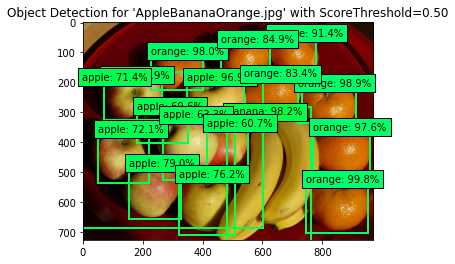

In [4]:
import numpy as np
import cv2

# First load and pre-process the image:
imgFileName = "AppleBananaOrange.jpg"
img = np.float32(cv2.imread(imgFileName)) # BGR format

# Scale the image to 512x512:
res = 512
imgH,imgW,_ = img.shape
imgSize = (imgW, imgH)
scaleX = np.float32(res) / imgW
scaleY = np.float32(res) / imgH
scaledImg = cv2.resize(img, (res, res),
                       interpolation = (cv2.INTER_AREA if scaleX<1.0 else cv2.INTER_CUBIC))
            
# Normalize the image
netInput = np.float32(scaledImg-[103.939, 116.779, 123.68])
netInput = np.transpose(netInput, (2,0,1))   # Onnx expects channel-first images

# Inference using the ONNX model and "onnxruntime"
import onnxruntime as ort
import matplotlib.pyplot as plt

session = ort.InferenceSession(onnxModel.SerializeToString(), None)

# Configuration for Inference:
boxesPerClass=20
iouThreshold=.45
scoreThreshold=.5

results = session.run(['BatchNums', 'Classes', 'Scores', 'Boxes', 'ClassNames'],
                      {'InputImage':[netInput],
                       'NmsBoxesPerClass':np.int64([boxesPerClass]), 
                       'NmsIouThreshold':np.float32([iouThreshold]),
                       'NmsScoreThreshold':np.float32([scoreThreshold])})
batchNums, classes, scores, boxes, classNames = results

classNames = str(classNames).split(',')  # className returned by the model is comma seperated list of labels

# Convert image to RGB to show it in matplotlib
img = (img/256)[..., ::-1]    
currentAxis = plt.gca()
colors = plt.cm.hsv(np.linspace(0, 1, 121)).tolist()

# Draw bounding boxes over the image:
dtNum = len(batchNums)
print("Number of detected objects: %d"%(dtNum))
for i in range(int(dtNum)):
    dtClass, dtBox, dtScore = int(classes[i]), boxes[i], scores[i][classes[i]]
    print("    %d: %s (%d%%) at %s"%(i, classNames[dtClass],int(dtScore*100),str(dtBox)))

    caption = "%s: %2.1f%%"%(classNames[ dtClass ], dtScore*100)
    dtBox *= [imgW,imgH,imgW,imgH]
    x,y, w,h = np.int32( np.rint(dtBox) )
    w-=x
    h-=y
    
    currentAxis.add_patch(plt.Rectangle((x,y), w,h, fill=False, edgecolor=colors[ dtClass ], linewidth=2))
    currentAxis.text(x,y, caption, bbox={'facecolor':colors[ dtClass ]}, verticalalignment='top')

imgplot = plt.imshow(img)
plt.title("Object Detection for '%s' with ScoreThreshold=%.2f"%(imgFileName, scoreThreshold))
plt.show()

## Where do I go from here?

[Exporting SSD Model to CoreML](SSD-CoreML.ipynb)

[Exporting SSD Model to TensorFlow](SSD-TF.ipynb)

---

[Fireball Playgrounds](../Contents.ipynb)

[Object Detection with SSD](SSD.ipynb)

[Reducing number of parameters of SSD Model](SSD-Reduce.ipynb)

[Pruning the SSD Model](SSD-Prune.ipynb)

[Quantizing SSD Model](SSD-Quantize.ipynb)
